In [1]:
import random
import os

from transformers import (
    MaskFormerConfig,
    MaskFormerImageProcessor,
    MaskFormerModel,
    MaskFormerForInstanceSegmentation
)

from huggingface_hub import notebook_login
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from datasets import load_dataset
import matplotlib.pyplot as plt
import albumentations as A
from tqdm import tqdm
from torch import nn
import pandas as pd
import numpy as np
import evaluate
import torch


In [2]:
ROOT_PATH = '/'.join(os.getcwd().split('/')[:-2])
DATA_PATH = f'{ROOT_PATH}/dataset/placeschallenge'

In [3]:
train = load_dataset('scene_parse_150', 'instance_segmentation', split = 'train')
valid = load_dataset('scene_parse_150', 'instance_segmentation', split = 'validation')
test  = load_dataset('scene_parse_150', 'instance_segmentation', split = 'test')

Found cached dataset scene_parse_150 (/home/jovyan/.cache/huggingface/datasets/scene_parse_150/instance_segmentation/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75)
Found cached dataset scene_parse_150 (/home/jovyan/.cache/huggingface/datasets/scene_parse_150/instance_segmentation/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75)
Found cached dataset scene_parse_150 (/home/jovyan/.cache/huggingface/datasets/scene_parse_150/instance_segmentation/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75)


In [4]:
print(train[0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7FC2CBEC2130>, 'annotation': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7FC2CBD5B340>}


In [5]:
idx        = random.randint(0, len(train))
image      = np.array(train[idx]['image'].convert('RGB'))
annotation = np.array(train[idx]['annotation'])

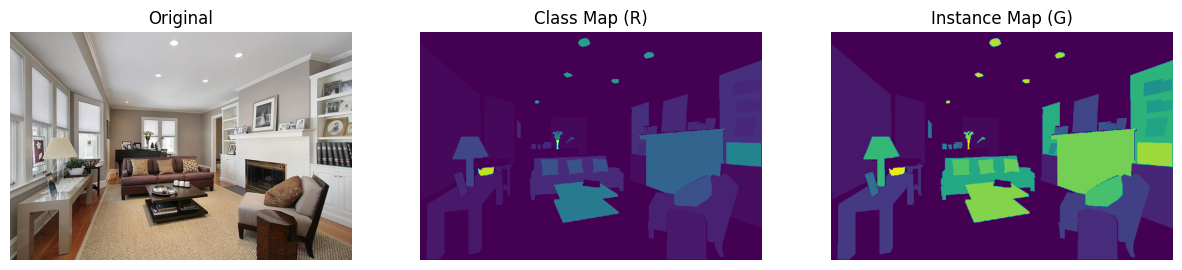

In [6]:
plt.figure(figsize = (15, 5))
for plot_index in range(3):
    
    if plot_index == 0:
        plot_image = image
        title = 'Original'
        
    else:
        plot_image = annotation[..., plot_index - 1]
        title     = ['Class Map (R)', 'Instance Map (G)'][plot_index - 1]
        
    
    plt.subplot(1, 3, plot_index + 1)
    plt.imshow(plot_image)
    plt.title(title)
    plt.axis('off')

In [7]:
processor = MaskFormerImageProcessor(
    reduce_labels = True,
    size          = (512, 512),
    ignore_index  = 255,
    do_resize     = False,
    do_rescale    = False,
    do_normalize  = False
)

/opt/conda/envs/tensor/lib/python3.8/site-packages/transformers/models/maskformer/image_processing_maskformer.py:421: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [8]:
model_name = 'facebook/maskformer-swin-base-ade'
config     = MaskFormerConfig.from_pretrained(model_name)

In [9]:
data = pd.read_csv(
    f'{DATA_PATH}/instanceInfo100_train.txt', sep = '\t',
    header = 0, on_bad_lines = 'skip'
)

idx2lb = {idx : lb.strip() for idx, lb in enumerate(data['Object Names'])}
lb2idx = {v : k for k, v in idx2lb.items()}

config.idx2lb = idx2lb
config.lb2idx = lb2idx

In [10]:
model      = MaskFormerForInstanceSegmentation(config)
base_model = MaskFormerModel.from_pretrained(model_name)
model.mode = base_model

Some weights of the model checkpoint at facebook/maskformer-swin-base-ade were not used when initializing MaskFormerModel: ['mask_embedder.1.0.bias', 'mask_embedder.0.0.weight', 'mask_embedder.2.0.weight', 'criterion.empty_weight', 'mask_embedder.0.0.bias', 'class_predictor.bias', 'mask_embedder.2.0.bias', 'class_predictor.weight', 'mask_embedder.1.0.weight']
- This IS expected if you are initializing MaskFormerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MaskFormerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD  = np.array([58.395, 57.120, 57.375]) / 255

In [12]:
train_val_transform = A.Compose([
    A.Resize(width = 512, height = 512),
    A.HorizontalFlip(p = 0.3),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD)
])

In [13]:
class ImageSegmentationDataset(Dataset):
    
    def __init__(self, dataset, processor, transform = None):
        
        self.dataset   = dataset
        self.processor = processor
        self.transform = transform
        
    
    def __len__(self): return len(self.dataset)


    def __getitem__(self, idx):
        
        image = np.array(self.dataset[idx]['image'].convert('RGB'))
        
        instance_seg = np.array(self.dataset[idx]['annotation'])[..., 1]
        class_id_map = np.array(self.dataset[idx]['annotation'])[..., 0]
        
        class_labels = np.unique(class_id_map)
        instance2class = {}
        for lb in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == lb])
            instance2class.update({i : lb for i in instance_ids})
            
        if self.transform is not None:
            
            transformed           = self.transform(image = image, mask = instance_seg)
            (image, instance_seg) = (transformed['image'], transformed['mask'])
            
            image = image.transpose(2, 0, 1)
            
        
        conditions = [class_labels.shape[0] == 1, class_labels[0] == 0]
        if all(conditions):
            
            inputs = self.processor([image], return_tensors = 'pt')
            inputs = {k : v.squeeze() for k, v in inputs.items()}
            
            inputs['class_labels'] = torch.tensor([0])
            inputs['mask_labels']  = torch.zeros(
                                    (0, inputs['pixel_values'].shape[-2], inputs['pixel_values'].shape[-1])
                                )
        else:
            inputs = self.processor(
                        [image], [instance_seg],
                        instance_id_to_semantic_id = instance2class,
                        return_tensors = 'pt'
                    )
            
            inputs = {k : v.squeeze() if isinstance(v, torch.Tensor)
                                      else v[0] for k, v in inputs.items()}
        
        return inputs

In [14]:
train_dataset = ImageSegmentationDataset(train, processor = processor,
                                        transform = train_val_transform)

valid_dataset = ImageSegmentationDataset(valid, processor = processor,
                                        transform = train_val_transform)

In [15]:
inputs  = dict(sorted(valid_dataset[0].items(), key = lambda x: len(x[0])))
max_len = max([len(k) for k in inputs.keys()])

for k, v in inputs.items(): 
    print(f'{k} {" "*(max_len - len(k))}shape : {v.shape}')

pixel_mask   shape : torch.Size([512, 512])
mask_labels  shape : torch.Size([4, 512, 512])
pixel_values shape : torch.Size([3, 512, 512])
class_labels shape : torch.Size([4])


In [16]:
def collate_fn(samples):
    
    pixel_values = torch.stack([sample['pixel_values'] for sample in samples])
    pixel_mask   = torch.stack([sample['pixel_mask']   for sample in samples])
    
    mask_labels  = [sample['mask_labels'] for sample in samples]
    class_labels = [sample['class_labels'] for sample in samples]
    
    return {
        'pixel_values' : pixel_values,
        'pixel_mask'   : pixel_mask,
        'mask_labels'  : mask_labels,
        'class_labels' : class_labels
        
    }
                           
                           

train_loader = DataLoader(
    train_dataset, batch_size = 4,
    shuffle = True, collate_fn = collate_fn
)

valid_loader = DataLoader(
    valid_dataset, batch_size = 4,
    shuffle = False, collate_fn = collate_fn
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


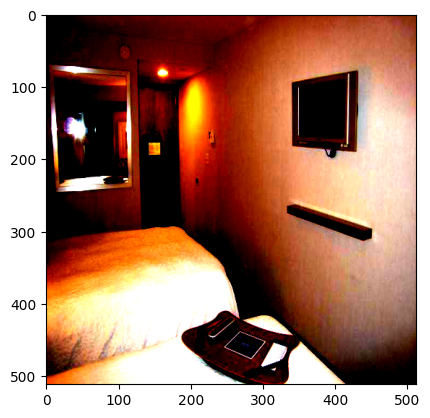

In [17]:
sample = next(iter(train_loader))
sample = np.transpose(sample['pixel_values'][0].squeeze(), (1, 2, 0))

plt.imshow(sample)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer  = torch.optim.Adam(model.parameters(), lr = 5e-5)
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    
    print(f'[{epoch} / {num_epochs}] Training')
    model.train()
    
    train_loss, valid_loss = [], []
    for idx, batch in enumerate(tqdm(train_loader)):
        
        optimizer.zero_grad()
        outputs = model(
            pixel_values = batch['pixel_values'].to(device),
            mask_labels  = [labels.to(device) for labels in batch['mask_labels']],
            class_labels = [labels.to(device) for labels in batch['class_labels']]
        )
        
        loss = outputs.loss
        train_loss.append(loss.item())
        loss.backward()
        
        if idx % 1000 == 0:
            print(f'[{epoch} / {num_epochs}] training loss : {round(sum(train_loss)/ len(train_loss), 3)}')
        
        
        optimizer.step()
        
    train_loss = sum(train_loss) / len(train_loss)
    model.eval()
    
    start_idx = 0
    print(f'[{epoch} / {num_epochs}] Validation')
    
    for idx, batch in enumerate(tqdm(valid_loader)):
        
        with torch.no_grad():
            outputs = model(
                pixel_values = batch['pixel_values'].to(device),
                mask_labels  = [labels.to(device) for labels in batch['mask_labels']],
                class_labels = [labels.to(device) for labels in batch['class_labels']]
                
            )
            
            loss = outputs.loss
            valid_loss.append(loss.item())
            
            if idx % 1000 == 0:
                print(f'[{epoch} / {num_epochs}] validation loss : {round(sum(valid_loss)/ len(valid_loss), 3)}')
            
    valid_loss = sum(valid_loss) / len(valid_loss)
    
    print(f'[{epoch} / {num_epochs}] train loss : {train_loss} | valid loss : {valid_loss}')

[1 / 10] Training


  0%|          | 0/5053 [00:00<?, ?it/s]

[1 / 10] training loss : 27.525


 20%|█▉        | 1001/5053 [21:09<1:35:19,  1.41s/it]

[1 / 10] training loss : 3.869


 40%|███▉      | 2001/5053 [39:42<43:17,  1.17it/s]  

[1 / 10] training loss : 3.725


 59%|█████▉    | 3001/5053 [52:29<17:16,  1.98it/s]

[1 / 10] training loss : 3.666


 79%|███████▉  | 4001/5053 [1:00:54<09:09,  1.91it/s]

[1 / 10] training loss : 3.622


 99%|█████████▉| 5000/5053 [1:12:06<00:59,  1.13s/it]

[1 / 10] training loss : 3.596


100%|██████████| 5053/5053 [1:13:07<00:00,  1.15it/s]


[1 / 10] Validation


  0%|          | 1/500 [00:01<14:33,  1.75s/it]

[1 / 10] validation loss : 4.603


100%|██████████| 500/500 [08:01<00:00,  1.04it/s]


[1 / 10] train loss : 3.594164324023807 | valid loss : 3.892769665956497
[2 / 10] Training


  0%|          | 1/5053 [00:00<1:15:08,  1.12it/s]

[2 / 10] training loss : 3.034


 20%|█▉        | 1001/5053 [20:14<1:09:28,  1.03s/it]

[2 / 10] training loss : 3.44


 40%|███▉      | 2001/5053 [39:35<51:23,  1.01s/it]  

[2 / 10] training loss : 3.44


 59%|█████▉    | 3001/5053 [52:31<18:10,  1.88it/s]  

[2 / 10] training loss : 3.441


 79%|███████▉  | 4001/5053 [1:00:57<08:30,  2.06it/s]

[2 / 10] training loss : 3.415


 99%|█████████▉| 5001/5053 [1:09:25<00:25,  2.01it/s]

[2 / 10] training loss : 3.405


100%|██████████| 5053/5053 [1:09:52<00:00,  1.21it/s]


[2 / 10] Validation


  0%|          | 1/500 [00:00<02:43,  3.06it/s]

[2 / 10] validation loss : 4.43


 79%|███████▉  | 397/500 [01:54<00:29,  3.47it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 20%|█▉        | 1001/5053 [08:35<32:07,  2.10it/s]

[3 / 10] training loss : 3.329


 40%|███▉      | 2001/5053 [17:09<25:41,  1.98it/s]

[3 / 10] training loss : 3.313


 59%|█████▉    | 3001/5053 [25:43<18:31,  1.85it/s]

[3 / 10] training loss : 3.3


 79%|███████▉  | 4001/5053 [34:24<09:49,  1.78it/s]

[3 / 10] training loss : 3.297


 99%|█████████▉| 5001/5053 [44:49<00:51,  1.02it/s]

[3 / 10] training loss : 3.294


100%|██████████| 5053/5053 [45:31<00:00,  1.85it/s]


[3 / 10] Validation


  0%|          | 1/500 [00:00<06:13,  1.34it/s]

[3 / 10] validation loss : 5.065


100%|██████████| 500/500 [04:55<00:00,  1.69it/s]


[3 / 10] train loss : 3.293233292777067 | valid loss : 5.315623212814331
[4 / 10] Training


  0%|          | 1/5053 [00:01<1:33:40,  1.11s/it]

[4 / 10] training loss : 3.394


 20%|█▉        | 1001/5053 [14:08<57:12,  1.18it/s] 

[4 / 10] training loss : 3.258


 40%|███▉      | 2001/5053 [28:21<42:31,  1.20it/s]  

[4 / 10] training loss : 3.262


 59%|█████▉    | 3001/5053 [41:59<26:12,  1.31it/s]

[4 / 10] training loss : 3.24


 79%|███████▉  | 4001/5053 [50:41<09:10,  1.91it/s]

[4 / 10] training loss : 3.227


 99%|█████████▉| 5001/5053 [59:04<00:25,  2.02it/s]

[4 / 10] training loss : 3.217


100%|██████████| 5053/5053 [59:31<00:00,  1.41it/s]


[4 / 10] Validation


  0%|          | 1/500 [00:00<03:05,  2.69it/s]

[4 / 10] validation loss : 4.485


100%|██████████| 500/500 [02:22<00:00,  3.51it/s]


[4 / 10] train loss : 3.2161577586523262 | valid loss : 4.378545183420181
[5 / 10] Training


  0%|          | 1/5053 [00:00<41:44,  2.02it/s]

[5 / 10] training loss : 3.286


 20%|█▉        | 1001/5053 [08:35<36:14,  1.86it/s]

[5 / 10] training loss : 3.166


 40%|███▉      | 2001/5053 [17:14<26:35,  1.91it/s]

[5 / 10] training loss : 3.16


 59%|█████▉    | 3001/5053 [25:52<18:01,  1.90it/s]

[5 / 10] training loss : 3.149


 79%|███████▉  | 4001/5053 [34:32<08:41,  2.02it/s]

[5 / 10] training loss : 3.147


 99%|█████████▉| 5001/5053 [43:09<00:25,  2.02it/s]

[5 / 10] training loss : 3.142


100%|██████████| 5053/5053 [43:35<00:00,  1.93it/s]


[5 / 10] Validation


  0%|          | 1/500 [00:00<03:04,  2.71it/s]

[5 / 10] validation loss : 4.503


100%|██████████| 500/500 [02:25<00:00,  3.43it/s]


[5 / 10] train loss : 3.142150053907427 | valid loss : 4.010227064490318
[6 / 10] Training


  0%|          | 1/5053 [00:00<39:35,  2.13it/s]

[6 / 10] training loss : 2.693


 20%|█▉        | 1001/5053 [12:58<1:13:54,  1.09s/it]

[6 / 10] training loss : 3.088


 40%|███▉      | 2000/5053 [29:28<1:06:29,  1.31s/it]

[6 / 10] training loss : 3.113


 59%|█████▉    | 3001/5053 [46:37<36:49,  1.08s/it]  

[6 / 10] training loss : 3.097


 79%|███████▉  | 4001/5053 [1:03:47<17:59,  1.03s/it]

[6 / 10] training loss : 3.088


 99%|█████████▉| 5001/5053 [1:21:33<01:00,  1.16s/it]

[6 / 10] training loss : 3.085


100%|██████████| 5053/5053 [1:22:24<00:00,  1.02it/s]


[6 / 10] Validation


  0%|          | 1/500 [00:01<10:51,  1.31s/it]

[6 / 10] validation loss : 4.508


100%|██████████| 500/500 [07:13<00:00,  1.15it/s]


[6 / 10] train loss : 3.086055924325987 | valid loss : 4.003707313060761
[7 / 10] Training


  0%|          | 1/5053 [00:01<1:54:21,  1.36s/it]

[7 / 10] training loss : 2.747


 20%|█▉        | 1001/5053 [16:29<59:40,  1.13it/s] 

[7 / 10] training loss : 3.054


 40%|███▉      | 2001/5053 [30:15<43:34,  1.17it/s]  

[7 / 10] training loss : 3.043


 59%|█████▉    | 3001/5053 [41:44<18:24,  1.86it/s]

[7 / 10] training loss : 3.046


 79%|███████▉  | 4001/5053 [50:19<08:43,  2.01it/s]

[7 / 10] training loss : 3.032


 99%|█████████▉| 5001/5053 [58:51<00:25,  2.07it/s]

[7 / 10] training loss : 3.028


100%|██████████| 5053/5053 [59:16<00:00,  1.42it/s]


[7 / 10] Validation


  0%|          | 1/500 [00:00<02:44,  3.04it/s]

[7 / 10] validation loss : 4.72


100%|██████████| 500/500 [02:17<00:00,  3.63it/s]


[7 / 10] train loss : 3.0291956698283475 | valid loss : 4.356324131250381
[8 / 10] Training


  0%|          | 1/5053 [00:00<46:13,  1.82it/s]

[8 / 10] training loss : 3.881


 20%|█▉        | 1001/5053 [08:37<33:21,  2.02it/s]

[8 / 10] training loss : 3.004


 40%|███▉      | 2001/5053 [16:58<25:23,  2.00it/s]

[8 / 10] training loss : 3.0


 59%|█████▉    | 3001/5053 [25:25<18:15,  1.87it/s]

[8 / 10] training loss : 2.987


 79%|███████▉  | 4001/5053 [33:51<08:17,  2.12it/s]

[8 / 10] training loss : 2.98


 99%|█████████▉| 5001/5053 [42:13<00:24,  2.09it/s]

[8 / 10] training loss : 2.981


100%|██████████| 5053/5053 [42:39<00:00,  1.97it/s]


[8 / 10] Validation


  0%|          | 1/500 [00:00<02:58,  2.79it/s]

[8 / 10] validation loss : 4.395


 68%|██████▊   | 339/500 [01:36<00:44,  3.65it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 20%|█▉        | 1001/5053 [08:18<33:28,  2.02it/s]

[9 / 10] training loss : 2.938


 40%|███▉      | 2001/5053 [16:45<26:28,  1.92it/s]

[9 / 10] training loss : 2.951


 59%|█████▉    | 3001/5053 [25:03<17:25,  1.96it/s]

[9 / 10] training loss : 2.938


 79%|███████▉  | 4001/5053 [33:21<08:25,  2.08it/s]

[9 / 10] training loss : 2.93


 99%|█████████▉| 5001/5053 [41:52<00:27,  1.92it/s]

[9 / 10] training loss : 2.93


100%|██████████| 5053/5053 [42:19<00:00,  1.99it/s]


[9 / 10] Validation


  0%|          | 1/500 [00:00<02:46,  3.00it/s]

[9 / 10] validation loss : 4.802


100%|██████████| 500/500 [02:20<00:00,  3.57it/s]


[9 / 10] train loss : 2.930076711748275 | valid loss : 4.821146612405777
[10 / 10] Training


  0%|          | 1/5053 [00:00<49:00,  1.72it/s]

[10 / 10] training loss : 3.911


  7%|▋         | 342/5053 [02:55<37:16,  2.11it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 59%|█████▉    | 3001/5053 [25:08<16:33,  2.07it/s]

[10 / 10] training loss : 2.906


 79%|███████▉  | 4001/5053 [33:28<08:26,  2.08it/s]

[10 / 10] training loss : 2.902


 99%|█████████▉| 5001/5053 [41:51<00:25,  2.01it/s]

[10 / 10] training loss : 2.892


100%|██████████| 5053/5053 [42:17<00:00,  1.99it/s]


[10 / 10] Validation


  0%|          | 1/500 [00:00<02:43,  3.04it/s]

[10 / 10] validation loss : 4.954


100%|██████████| 500/500 [02:22<00:00,  3.50it/s]

[10 / 10] train loss : 2.891570607798538 | valid loss : 4.389821337938309


In [19]:
def infer(dataset, model, processor):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model  = model.to(device)
    
    index       = random.randint(0, len(test))
    image       = test[index]['image'].convert('RGB')
    target_size = image.size[::-1]
    
    inputs      = processor(images = image, return_tensors = 'pt').to(device)
    
    inputs['pixel_values'] = inputs['pixel_values'].to(device, dtype = torch.float32)
    inputs['pixel_mask']   = inputs['pixel_mask'].to(device, dtype = torch.float32)

    model.eval()
    with torch.no_grad(): outputs = model(**inputs)
    
    for k, v in outputs.items(): print(f'{k} : {v.shape}')
    
    result = processor.post_process_instance_segmentation(
                outputs, threshold = 0.5, target_sizes = [target_size]
            )[0]
    
    instance_seg_mask = result['segmentation'].cpu().detach().numpy()
    for info in result['segments_info']: print(f'{info}')
    
    return instance_seg_mask

    
def visualize_instance_seg_mask(mask):
    
    image    = np.zeros((mask.shape[0], mask.shape[1], 3))
    labels   = np.unique(mask)
    lb2color = {
            label : (
                    random.randint(0, 255),
                    random.randint(0, 255),
                    random.randint(0, 255),
                )
                for label in labels
            }
    
    for height in range(image.shape[0]):
        
        for width in range(image.shape[1]):
            image[height, width, :] = lb2color[mask[height, width]]
            
    image = image / 255
    return image

class_queries_logits : torch.Size([1, 100, 151])
masks_queries_logits : torch.Size([1, 100, 128, 171])
encoder_last_hidden_state : torch.Size([1, 1024, 16, 22])
pixel_decoder_last_hidden_state : torch.Size([1, 256, 128, 171])
transformer_decoder_last_hidden_state : torch.Size([1, 100, 256])


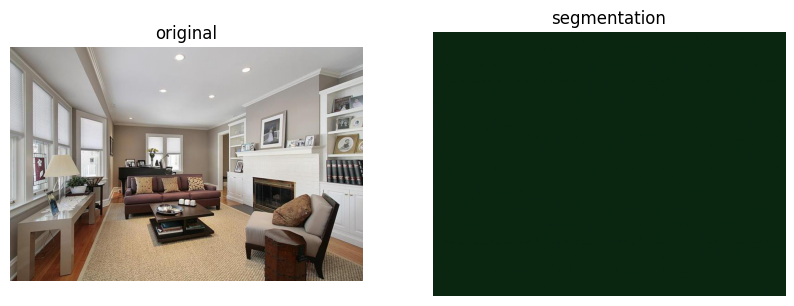

In [20]:
mask      = infer(test, model, processor)
mask_disp = visualize_instance_seg_mask(mask)

plt.figure(figsize = (10, 10))
for plot_idx in range(2):
    
    if plot_idx == 0:
        plot_image = image
        title      = 'original'
        
    else:
        plot_image = mask_disp
        title      = 'segmentation'
        
    
    plt.subplot(1, 2, plot_idx + 1)
    plt.imshow(plot_image)
    plt.title(title)
    plt.axis(False)

In [21]:
metrics = evaluate.load('mean_iou')

In [22]:
gt, preds = [], []
for idx in tqdm(range(200)):
    
    image       = valid[idx]['image'].convert('RGB')
    target_size = image.size[::-1]
    
    annotation  = np.array(valid[idx]['annotation'])[:, :, 0]
    annotation -= 1
    
    annotation[annotation == -1] = 255
    gt.append(annotation)
    
    inputs = processor(images = image, return_tensors = 'pt')
    inputs['pixel_values'] = inputs['pixel_values'].to(device, dtype = torch.float32)
    inputs['pixel_mask']   = inputs['pixel_mask'].to(device, dtype = torch.float32)
    
    model.eval()
    with torch.no_grad(): outputs = model(**inputs)
    
    result            = processor.post_process_semantic_segmentation(
                                    outputs, 
                                    target_sizes = [target_size])[0]
    
    semantic_seg_mask = result.cpu().detach().numpy()
    preds.append(semantic_seg_mask)
    
results = metrics.compute(
            predictions  = preds,
            references   = gt,
            num_labels   = 100,
            ignore_index = 255
        )

print(f'mIoU          : {results["mean_iou"]:.3f}')
print(f'mean Accuracy : {results["mean_accuracy"]:.3f}')
print(f'Overall       : {results["overall_accuracy"]:.3f}')

100%|██████████| 200/200 [00:14<00:00, 13.55it/s]
/home/jovyan/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/home/jovyan/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


mIoU          : 0.001
mean Accuracy : 0.013
Overall       : 0.045


In [23]:
len(valid)

2000